In [1]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct
from skimage.filters import gaussian
from scipy.optimize import LinearConstraint
import numpy as np
from copy import deepcopy

def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

def MSLE(arr1, arr2): # MEAN SQUARE LOG ERROR
    return np.nanmean((np.log(arr1 + 1) - np.log(arr2 + 1))**2)

def MSE(arr1, arr2):
    return np.nanmean((arr1 - arr2)**2)

def MLSE(arr1, arr2): # MEAN LOG SQUARE ERROR
    return np.nanmean(np.log((arr1 - arr2)**2 + 1))

def RMLSE(arr1, arr2):
    return np.sqrt(MLSE(arr1,arr2))

def RMSLE(arr1, arr2):
    return np.sqrt(MSLE(arr1, arr2))

loss_fns = [MSLE, MSE, MLSE, RMLSE, RMSLE]

def lorentzian_2d_DoG(amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    lorentz =  amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2) + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset * 10
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    DoG = DoG
    return lorentz * DoG 

def symmetric_moffat_DoG(amplitude, xo, yo, alpha_x, alpha_y, beta, offset, sigma1, sigma2, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    moffat_term = amplitude * (1 + ((x - xo)**2 / alpha_x**2) + ((y - yo)**2 / alpha_x**2)) ** (-beta)# + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    
    return moffat_term * DoG

def check_zero_cost(intermediate_result):
    if intermediate_result.fun == 0:
        print(f"Cost is zero for parameters: {intermediate_result.x}")
    return False  # return True if you want to stop the optimization here

def perc_err(act,exp):
    return abs((act - exp)/exp) * 100

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

In [2]:
def fit_moffat(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'alpha_x': (0.001, 50),
        'alpha_y': (0.001, 50),
        'beta': (0.01, 20,),
        'offset': (0, 3),
        'sigma1': (1, 50),
        'sigma2': (1, 50),
        'amplitude_gauss1': (0, 10),
        'amplitude_gauss2': (0, 10),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 24, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF))
    return result


In [7]:
def get_real_PSF(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        :, # 23 Z stacks total
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    real_PSF = real_PSF[peak_intensity_z-10:peak_intensity_z+10]
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean())
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.sum()
    return real_PSF

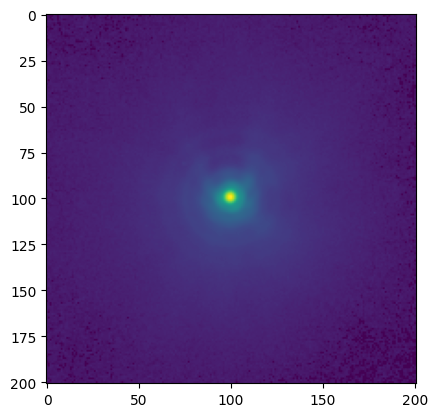

In [6]:
plt.imshow(
    get_real_PSF(201)**(1/3)
)

In [8]:
def fit_lorentz(real_PSF, error_function, xdata_tuple):
    param_bounds = {
        'amplitude': (0, 5),
        'xo': (0, real_PSF.shape[1]),
        'yo': (0, real_PSF.shape[0]),
        'gamma_x': (0.001, 50),
        'gamma_y': (0.001, 50),
        'sigma1': (1, 20),
        'sigma2': (1, 20),
        'offset': (0, 3),
        'amplitude_gauss1': (0, 10),
        'amplitude_gauss2': (0, 10),
    }
    
    # Create bounds for optimization
    lower_bounds = [param_bounds[name][0] for name in param_bounds]
    upper_bounds = [param_bounds[name][1] for name in param_bounds]
    bounds = Bounds(lower_bounds, upper_bounds)
    
    
    
    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 1, -1],  # amplitude_gauss2 - amplitude_gauss1  > 0
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps, np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf, np.inf]                            # Upper bounds are infinity

    # Define the constraint matrix
    A = np.array([
        [0, 0, 0, 0, 0, 1, -1, 0, 0, 0]   # sigma2 - sigma1 > 0 (equivalent to sigma1 < sigma2)
    ])
    
    # Define the lower and upper bounds for the inequalities
    lb = [np.finfo(float).eps]  # Lower bounds slightly above 0
    ub = [np.inf]    
    
    # Create the LinearConstraint object
    constraints = LinearConstraint(A, lb, ub)


    result = differential_evolution(error_function, bounds, workers = 24, disp = False, callback = check_zero_cost, args = (xdata_tuple, real_PSF), constraints = constraints, updating='deferred')
    return result


In [9]:
def fit_to_PSF(PSF_size_xyz, parameterised_function, fit_function, error_function):

    real_PSF_stack = get_real_PSF(PSF_size_xyz)
    x = np.linspace(0, real_PSF_stack.shape[2]-1, real_PSF_stack.shape[1])
    y = np.linspace(0, real_PSF_stack.shape[1]-1, real_PSF_stack.shape[1])

    losses = []
    results = []
    for PSF_slice in real_PSF_stack:
        x, y = xdata_tuple = np.meshgrid(x, y)
        
        
    
        result = fit_function(real_PSF, error_function, xdata_tuple)
        results.append(result)
        #print(result)
        best_fit = parameterised_function(*result.x, (x,y))
        
        MSE_loss = MSLE(best_fit, real_PSF)
        losses.append(MSE_loss)
        #plt.plot(best_fit[best_fit.shape[0]//2])
        #plt.plot(get_midline_rotate_method(real_PSF), label = "real")
    
        #plt.yscale("log")
        #plt.title("Fit")
        #plt.show()
    
    MSE_loss = np.mean(MSE_loss)
    return result, MSE_loss, get_midline_rotate_method(best_fit)

def get_extrapolated_fit(result, original_fit_xy, parameterised_function, error_function):
    real_PSF = get_real_PSF(201)
    x = np.linspace(0, real_PSF.shape[1]-1, real_PSF.shape[1])
    y = np.linspace(0, real_PSF.shape[0]-1, real_PSF.shape[0])
    x, y = xdata_tuple = np.meshgrid(x, y)
    best_fit_result = deepcopy(result.x)
    #best_fit_result[1] = best_fit_result[2] = real_PSF.shape[1]/2
    best_fit_result[2] = best_fit_result[2] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit_result[1] = best_fit_result[1] + real_PSF.shape[1]/2 - original_fit_xy/2
    best_fit = parameterised_function(*best_fit_result, (x,y))

    #plt.plot(best_fit[best_fit.shape[0]//2])
    #plt.plot(get_midline_rotate_method(real_PSF), label = "real")
    #plt.plot(real_PSF[real_PSF.shape[0]//2], label = "real")

    #plt.yscale("log")
    #plt.title("Extrapolation")
    #plt.show()
    MSE_loss = MSLE(best_fit, real_PSF)
    return error_function(best_fit_result, xdata_tuple, real_PSF), MSE_loss, get_midline_rotate_method(best_fit), get_midline_rotate_method(real_PSF)

In [ ]:
fit_to_PSF()

Lowest MSLE = 1.358825623397821e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 4.446606704138314e-05
                   x: [ 9.885e-01  2.461e+01  2.445e+01  2.022e+00
                        1.955e+00  1.336e+01  1.311e+01  4.199e-04
                        2.367e+00  1.125e+00]
                 nit: 213
                nfev: 27416
          population: [[ 4.579e-01  2.461e+01 ...  2.767e+00  9.039e-02]
                       [ 4.593e-01  2.465e+01 ...  2.732e+00  6.981e-02]
                       ...
                       [ 4.841e-01  2.459e+01 ...  2.531e+00  2.340e-02]
                       [ 4.238e-01  2.460e+01 ...  3.172e+00  2.515e-01]]
 population_energies: [ 4.447e-05  4.502e-05 ...  4.494e-05  4.500e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                               0.000e+00,  0

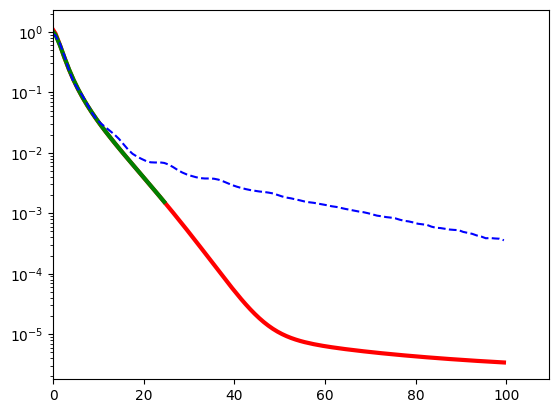

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.046467874104131e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 4.769226167319205e-05
                   x: [ 4.985e+00  2.460e+01  2.442e+01  3.513e+00
                        3.373e+00  2.514e+00  2.513e+00  6.402e-03
                        3.795e+00  3.643e+00]
                 nit: 272
                nfev: 39684
          population: [[ 6.225e-01  2.460e+01 ...  6.694e+00  4.822e+00]
                       [ 5.886e-01  2.460e+01 ...  5.743e+00  3.741e+00]
                       ...
                       [ 6.249e-01  2.461e+01 ...  6.566e+00  4.692e+00]
                       [ 6.217e-01  2.461e+01 ...  5.243e+00  3.350e+00]]
 population_energies: [ 4.769e-05  7.377e-05 ...  7.347e-05  7.409e-05]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                               0.000e+00,  0

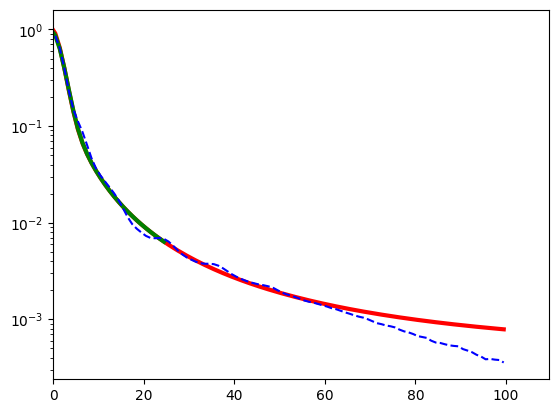

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Lowest MSLE = 1.0463067185195022e-05
             message: Optimization terminated successfully.
             success: True
                 fun: 0.006904764114909076
                   x: [ 5.000e+00  2.460e+01  2.442e+01  3.511e+00
                        3.371e+00  2.540e+00  2.539e+00  6.390e-03
                        4.269e-01  2.760e-01]
                 nit: 339
                nfev: 46020
          population: [[ 4.488e+00  2.459e+01 ...  2.270e-01  5.651e-02]
                       [ 3.354e+00  2.457e+01 ...  2.954e-01  6.034e-02]
                       ...
                       [ 3.548e+00  2.460e+01 ...  2.494e-01  3.632e-02]
                       [ 3.720e+00  2.460e+01 ...  2.305e-01  2.432e-02]]
 population_energies: [ 6.905e-03  7.191e-03 ...  7.113e-03  7.096e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                               0.000e+00,  0

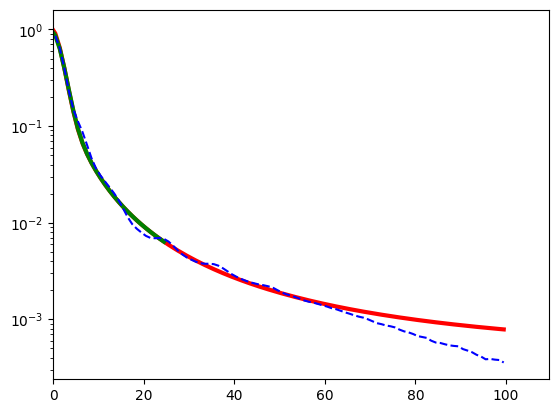

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better resu

In [ ]:
results = []
lowest_MSE_loss = 10
while True:
    for loss_fn in loss_fns:
    
        def error_function(params, *args):
            synthetic = lorentzian_2d_DoG(*params, args[0])
            return loss_fn(synthetic, args[1])
    
        #print(loss_fn)
        small_fit_size = 50
        result, MSE_loss_50px, fit_midline = fit_to_PSF(small_fit_size, lorentzian_2d_DoG, fit_lorentz, error_function)
        #print(f"50px fit = {MSE_loss_50px}")
        extrapolated_fit, MSE_loss_extrapolated, extrapolated_midline, real_PSF_midline = get_extrapolated_fit(result, small_fit_size, lorentzian_2d_DoG, error_function)
        #print(f"Extrapolated fit = {MSE_loss_extrapolated}")
        
        results.append([result, MSE_loss_extrapolated])
        if MSE_loss_extrapolated < lowest_MSE_loss:
            print(f"Lowest MSLE = {MSE_loss_extrapolated}")
            print(result)
            lowest_MSE_loss = MSE_loss_extrapolated

    
            extrapolated_x = np.arange(-201/2, 201/2)
            fit_x = np.arange(-len(fit_midline)/2, len(fit_midline)/2)
        
            
            plt.plot(extrapolated_x, extrapolated_midline, c = "red", linewidth = 3)
            plt.plot(fit_x, fit_midline, c = "green", linewidth = 3)
            plt.plot(extrapolated_x, real_PSF_midline,  c = "blue", linestyle = "--")
            plt.yscale("log")
            #plt.xscale("log")
            plt.xlim(0,)
            plt.show()

        #result_full_fit, MSE_loss_201px = fit_to_PSF(201, lorentzian_2d_DoG, fit_lorentz, error_function)
        #print(f"201px fit = {MSE_loss_201px}")
        #print(f"Percentage difference = {perc_err(MSE_loss_extrapolated,MSE_loss_201px)}")


In [ ]:
    plt.plot(extrapolated_x, extrapolated_midline, c = "red", linewidth = 3)
    plt.plot(fit_x, fit_midline, c = "green", linewidth = 3)
    plt.plot(extrapolated_x, real_PSF_midline,  c = "blue", linestyle = "--")
    
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(0,)
    plt.show()

In [ ]:
7

In [ ]:
weird = [1.423e+00,  2.468e+01,  2.444e+01,  1.959e+00,
                        1.935e+00,  7.848e+00,  8.946e+00,  9.100e-04,
                        5.928e+00,  5.448e+00]

In [ ]:
weird

In [ ]:
best_fit_result[6]

In [ ]:
best_fit_result[7]

In [ ]:
def lorentzian_2d_DoG(amplitude, xo, yo, gamma_x, gamma_y, sigma1, sigma2, offset, amplitude_gauss1, amplitude_gauss2, xdata_tuple):
    (x, y) = xdata_tuple
    lorentz =  amplitude / (1 + ((x - xo) / gamma_x)**2 + ((y - yo) / gamma_y)**2) + offset
    gaussian_term_1 = amplitude_gauss1 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma1**2)) + offset
    gaussian_term_2 = amplitude_gauss2 * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma2**2))
    DoG = (gaussian_term_1 - gaussian_term_2)
    DoG = DoG - min(0, DoG.min())
    return lorentz * DoG 

size = 50
original_fit_xy = 50
x = np.linspace(0, size-1, size)
y = np.linspace(0, size-1, size)
x, y = xdata_tuple = np.meshgrid(x, y)
best_fit_result = deepcopy(weird)
best_fit_result[2] = best_fit_result[2] + size/2 - original_fit_xy/2
best_fit_result[1] = best_fit_result[1] + size/2 - original_fit_xy/2
best_fit_result[6] = best_fit_result[5]/2
#best_fit_result[8] = 0.1
test = lorentzian_2d_DoG(*best_fit_result, xdata_tuple)

plt.imshow((test))
plt.colorbar()

In [ ]:
plt.plot(get_midline(test))
#plt.yscale("log")

In [ ]:
test

In [ ]:
def error_function(params, *args):
    synthetic = lorentzian_2d_DoG(*params, args[0])
    return MSE(synthetic, args[1])

In [ ]:
for loss_fn in loss_fns:

    def error_function(params, *args):
        synthetic = symmetric_moffat_DoG(*params, args[0])
        return loss_fn(synthetic, args[1])

    print(loss_fn)
    small_fit_size = 70
    result, MSE_loss_50px = fit_to_PSF(small_fit_size, symmetric_moffat_DoG, fit_moffat, error_function)
    print(f"50px fit = {MSE_loss_50px}")
    extrapolated_fit, MSE_loss_extrapolated = get_extrapolated_fit(result, small_fit_size, symmetric_moffat_DoG, error_function)
    print(f"Extrapolated fit = {MSE_loss_extrapolated}")
    #result_full_fit, MSE_loss_201px = fit_to_PSF(201)
    #print(f"201px fit = {MSE_loss_201px}")

    #print(f"Percentage difference = {perc_err(MSE_loss_extrapolated,MSE_loss_201px)}")
     

In [ ]:
result